Notebook for investigating the mask fraction divot.

# Load in imports and data

Last working weekly: w_2024_34

In [1]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
from lsst.skymap import Index2D
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import gc

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

# mean weighted variance
from lsst.drp.tasks.assemble_cell_coadd import AssembleCellCoaddTask
import lsst.afw.math as afwMath

In [2]:
# create and configure stats control object as seen in assemble_cell_coadd task
statsCtrl = afwMath.StatisticsControl()
statsCtrl.setAndMask(afwImage.Mask.getPlaneBitMask(("BAD", "NO_DATA", "SAT"))) # use default PlaneBitMasks from task
statsCtrl.setNanSafe(True)

In [3]:
max_mask_frac_list = np.append(np.arange(0.001, 0.02, 0.001), np.arange(0.02, 0.15, 0.01))
save_folder = '/sdf/group/rubin/user/mgorsuch/notebooks/cell_coadds/m_frac_divot/mean_input_frac_lists'

## Define methods

In [4]:
def get_patches(collection, tract):
    patches = []
    
    # look for deepCoaddCell objects rather than input warps
    # to ignore warps that failed to produce coadds
    for ref in butler.registry.queryDatasets('deepCoaddCell',
                                             physical_filter='HSC-I',
                                             collections=collection,
                                             instrument='HSC',
                                             skymap = 'hsc_rings_cells_v1',
                                             where=f'tract={tract}'):
        patches.append(ref.dataId.get('patch'))
    patches = np.unique(patches)

    return patches

In [5]:
def calc_m_frac(collection, tract):

    patches = get_patches(collection, tract)
    
    warp_mask_fractions = [[[[] for k in range(22)] for j in range(22)] for i in range(len(patches))]
    total_inputs = [[[0 for k in range(22)] for j in range(22)] for i in range(len(patches))]
    center_ra = [[[0 for k in range(22)] for j in range(22)] for i in range(len(patches))]
    center_dec = [[[0 for k in range(22)] for j in range(22)] for i in range(len(patches))]
    
    for patch_index, patch in enumerate(patches):
    
        # coadd info is not dependent on visits
        coadd = butler.get('deepCoaddCell', 
                         collections=collection, 
                         instrument='HSC', 
                         skymap = 'hsc_rings_cells_v1', 
                         tract = tract, 
                         patch=patch,
                         band='i',)
    
        wcs = coadd.wcs
    
        cell_list = list(coadd.cells.keys()) # skips indices that are empty
    
        # get the visits from a single patch
        visits = []
        for ref in butler.registry.queryDatasets('deepCoadd_directWarp',
                                                 physical_filter='HSC-I',
                                                 collections=collection,
                                                 instrument='HSC',
                                                 skymap = 'hsc_rings_cells_v1',
                                                 tract=tract,
                                                 patch=patch):
            visits.append(ref.dataId.get('visit'))
        visits = np.unique(visits)
    
        for visit_index, visit in enumerate(visits):
            warp = butler.get('deepCoadd_directWarp',
                               collections = collection,
                               instrument='HSC',
                               skymap = 'hsc_rings_cells_v1',
                               tract = tract,
                               patch = patch,
                               visit = visit)
        
            mask_frac_warp = butler.get('deepCoadd_directWarp_maskedFraction',
                               collections = collection,
                               instrument='HSC',
                               skymap = 'hsc_rings_cells_v1',
                               tract = tract,
                               patch = patch,
                               visit = visit)
    
            for cell_index in cell_list:
        
                cell = coadd.cells[cell_index]
        
                x_index = cell_index.x
                y_index = cell_index.y
    
                # check if cell uses warp, skip cell if not
                cell_inputs = list(cell.inputs)
                
                cell_visits = [input.visit for input in cell_inputs]
                if not (np.isin(visit, cell_visits)):
                    continue
                
                # avoid reassigning coordinates and inputs to cells for each visit
                if visit_index==0:
                    cell_center = cell.outer.bbox.getCenter()
                    cell_center_coord = wcs.pixelToSky(cell_center)
                    center_ra[patch_index][y_index][x_index] = cell_center_coord[0].asDegrees()
                    center_dec[patch_index][y_index][x_index] = cell_center_coord[1].asDegrees()
    
                    total_inputs[patch_index][y_index][x_index] = cell.visit_count
    
                bbox = cell.outer.bbox
                masked_im = warp[bbox].getMaskedImage()
                mask_frac_im = mask_frac_warp[bbox].array
    
                # calculate fraction of masked pixels for the area of the warp that covers this cell
                # TO-DO: see if removing nan pixels from the total pixel count is necessary
                total_pixels = bbox.area
                
                nan_count = np.count_nonzero(np.isnan(mask_frac_im))
                total_pixels = total_pixels - nan_count
                
                mask_frac = np.nansum(mask_frac_im[np.where(np.isfinite(mask_frac_im))])/total_pixels
                warp_mask_fractions[patch_index][y_index][x_index].append(mask_frac)
                
            warp = 0
            mask_frac_warp = 0
            
        coadd = 0
        gc.collect()
        
    total_inputs = np.array([x for xss in total_inputs for xs in xss for x in xs])
    
    center_ra = np.array([x for xss in center_ra for xs in xss for x in xs])
    center_dec = np.array([x for xss in center_dec for xs in xss for x in xs])

    return warp_mask_fractions, total_inputs, center_ra, center_dec, non_empty_cells

In [6]:
def calc_input_frac(collection, tract, max_mask_frac_list, warp_mask_fractions, total_inputs, center_ra, center_dec):
    mean_input_frac_list = []
    
    for max_mask_frac in max_mask_frac_list:
        mask_df = pd.DataFrame()
        patches = get_patches(collection, tract)
    
        warp_inputs = [[[0 for k in range(22)] for j in range(22)] for i in range(len(patches))]
        
        for patch_index, patch in enumerate(patches):
            
            # coadd info is not dependent on visits
            coadd = butler.get('deepCoaddCell', 
                             collections=collection, 
                             instrument='HSC', 
                             skymap = 'hsc_rings_cells_v1', 
                             tract = tract, 
                             patch=patch,
                             band='i',)
        
            cell_list = list(coadd.cells.keys()) # skips indices that are empty
        
            wcs = coadd.wcs
    
            for cell_index in cell_list:
                
                cell = coadd.cells[cell_index]
        
                x_index = cell_index.x
                y_index = cell_index.y
    
                for visit_index, mask_frac in enumerate(warp_mask_fractions[patch_index][y_index][x_index]):
                    if mask_frac >= max_mask_frac:
                        continue
        
                    warp_inputs[patch_index][y_index][x_index] += 1
    
            coadd = 0
    
        mask_df['center_ra'] = center_ra
        mask_df['center_dec'] = center_dec
    
        mask_df['warp_inputs'] = np.array([x for xss in warp_inputs for xs in xss for x in xs])
        mask_df['total_inputs'] = total_inputs
    
        mask_df = mask_df.drop_duplicates(subset=['center_ra', 'center_dec']) # remove overlapping cells due to patch overlap
    
        mask_df = mask_df.drop(mask_df[mask_df.total_inputs < 1].index)
        
        mask_df['input_fraction'] = mask_df['warp_inputs'] / mask_df['total_inputs']
    
        mean_input_frac_list.append(mask_df['input_fraction'].mean())
        
        mask_df = 0
        gc.collect()
        
    return mean_input_frac_list

Some methods for a single patch will be helpful for smaller analyses.

In [107]:
def calc_m_frac_patch(collection, tract, patch):

    warp_mask_fractions = [[[] for k in range(22)] for j in range(22)]
    total_inputs = [[0 for k in range(22)] for j in range(22)]
    center_ra = [[0 for k in range(22)] for j in range(22)]
    center_dec = [[0 for k in range(22)] for j in range(22)]
    
    # coadd info is not dependent on visits
    coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = tract, 
                     patch=patch,
                     band='i',)

    cell_list = list(coadd.cells.keys()) # skips indices that are empty

    # get the visits from a single patch
    visits = []
    for ref in butler.registry.queryDatasets('deepCoadd_directWarp',
                                             physical_filter='HSC-I',
                                             collections=collection,
                                             instrument='HSC',
                                             skymap = 'hsc_rings_cells_v1',
                                             tract=tract,
                                             patch=patch):
        visits.append(ref.dataId.get('visit'))
    visits = np.unique(visits)

    for visit_index, visit in enumerate(visits, start=0):

        warp = butler.get('deepCoadd_directWarp',
                           collections = collection,
                           instrument='HSC',
                           skymap = 'hsc_rings_cells_v1',
                           tract = tract,
                           patch = patch,
                           visit = visit)
    
        mask_frac_warp = butler.get('deepCoadd_directWarp_maskedFraction',
                           collections = collection,
                           instrument='HSC',
                           skymap = 'hsc_rings_cells_v1',
                           tract = tract,
                           patch = patch,
                           visit = visit)
    
        for cell_index in cell_list:
    
            cell = coadd.cells[cell_index]
    
            x_index = cell_index.x
            y_index = cell_index.y

            # avoid reassigning coordinates and inputs to cells for each visit
            if visit_index==0:
                total_inputs[y_index][x_index] = cell.visit_count

            # check if cell uses warp, skip cell if not
            cell_inputs = list(cell.inputs)
            cell_visits = [input.visit for input in cell_inputs]

            if not (np.isin(visit, cell_visits)):
                continue

            bbox = cell.outer.bbox
            masked_im = warp[bbox].getMaskedImage()
            mask_frac_im = mask_frac_warp[bbox].array
    
            # calculate fraction of masked pixels for the area of the warp that covers this cell
            # TO-DO: see if removing nan pixels from the total pixel count is necessary
            total_pixels = bbox.area
                
            nan_count = np.count_nonzero(np.isnan(mask_frac_im))
            total_pixels = total_pixels - nan_count
            
            mask_frac = np.nansum(mask_frac_im[np.where(np.isfinite(mask_frac_im))])/total_pixels
            warp_mask_fractions[y_index][x_index].append(mask_frac)
                
        warp = 0
        mask_frac_warp = 0
        
    coadd = 0
    gc.collect()
    
    total_inputs = np.array([x for xs in total_inputs for x in xs])
    filled_cells_frac = np.count_nonzero(total_inputs) / (22*22)
    
    return warp_mask_fractions, total_inputs, filled_cells_frac

In [35]:
def calc_input_frac_patch(collection, tract, patch, max_mask_frac_list, warp_mask_fractions, total_inputs):
    mean_input_frac_list = []

    # coadd info is not dependent on visits
    coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = tract, 
                     patch=patch,
                     band='i',)
    
    cell_list = list(coadd.cells.keys()) # skips indices that are empty
    
    for max_mask_frac in max_mask_frac_list:
        mask_df = pd.DataFrame()
    
        warp_inputs = [[0 for k in range(22)] for j in range(22)]
          
        for cell_index in cell_list:
            
            cell = coadd.cells[cell_index]
    
            x_index = cell_index.x
            y_index = cell_index.y

            for visit_index, mask_frac in enumerate(warp_mask_fractions[y_index][x_index]):
                if mask_frac >= max_mask_frac:
                    continue
    
                warp_inputs[y_index][x_index] += 1
    
        mask_df['warp_inputs'] = np.array([x for xs in warp_inputs for x in xs])
        mask_df['total_inputs'] = total_inputs
    
        mask_df = mask_df.drop(mask_df[mask_df.total_inputs < 1].index)

        
        mask_df['input_fraction'] = mask_df['warp_inputs'] / mask_df['total_inputs']
    
        mean_input_frac_list.append(mask_df['input_fraction'].mean())
        
        mask_df = 0
        gc.collect()
        
    coadd = 0
    gc.collect()
        
    return mean_input_frac_list

# Run Data

The data will be saved so that this should not be run every time.

## Tract 9813

In [7]:
tract = 9813

### 9813 with all masks interpolated

In [8]:
collection = 'u/mgorsuch/cell_coadds_tract_9813_all_34/20240921T195601Z'

config = warp_config = butler.get('makeDirectWarp_config', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = tract, 
                     patch=61,
                     band='i',)

print(config.preWarpInterpolation.value.badMaskPlanes)

patches = get_patches(collection, 9813)
print("Number of patches: ", len(patches))
cell_count = 0
for patch in patches:
    coadd = butler.get('deepCoaddCell', 
                         collections=collection, 
                         instrument='HSC', 
                         skymap = 'hsc_rings_cells_v1', 
                         tract = tract, 
                         patch=patch,
                         band='i',)

    cells = len(list(coadd.cells.keys())) # get number of non-empty cells
    cell_count += cells
    del coadd
    gc.collect()
print("Number of cells: ", cell_count)

['BAD', 'SAT', 'CR']
Number of patches:  33
Number of cells:  7657


In [9]:
warp_mask_fractions, total_inputs, center_ra, center_dec, non_empty_cells = calc_m_frac(collection, tract)
mean_input_frac_list = calc_input_frac(collection, tract, max_mask_frac_list, warp_mask_fractions, total_inputs, center_ra, center_dec)

input_frac_data = np.array([max_mask_frac_list, np.array(mean_input_frac_list)])
np.savetxt(f'{save_folder}/9813_all.txt', input_frac_data, delimiter=',')

### 9813 with only BAD mask interpolated

In [10]:
collection = 'u/mgorsuch/cell_coadds_tract_9813_bad_34/20240921T195746Z'

config = warp_config = butler.get('makeDirectWarp_config', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = tract, 
                     patch=61,
                     band='i',)

print(config.preWarpInterpolation.value.badMaskPlanes)

['BAD']


In [11]:
warp_mask_fractions, total_inputs, center_ra, center_dec, non_empty_cells = calc_m_frac(collection, tract)
mean_input_frac_list = calc_input_frac(collection, tract, max_mask_frac_list, warp_mask_fractions, total_inputs, center_ra, center_dec)

input_frac_data = np.array([max_mask_frac_list, np.array(mean_input_frac_list)])
np.savetxt(f'{save_folder}/9813_bad.txt', input_frac_data, delimiter=',')

### 9813 with only SAT mask interpolated

In [12]:
collection = 'u/mgorsuch/cell_coadds_tract_9813_sat_34/20240921T195845Z'

config = warp_config = butler.get('makeDirectWarp_config', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = tract, 
                     patch=61,
                     band='i',)

print(config.preWarpInterpolation.value.badMaskPlanes)

['SAT']


In [13]:
warp_mask_fractions, total_inputs, center_ra, center_dec, non_empty_cells = calc_m_frac(collection, tract)
mean_input_frac_list = calc_input_frac(collection, tract, max_mask_frac_list, warp_mask_fractions, total_inputs, center_ra, center_dec)

input_frac_data = np.array([max_mask_frac_list, np.array(mean_input_frac_list)])
np.savetxt(f'{save_folder}/9813_sat.txt', input_frac_data, delimiter=',')

### 9813 with only CR mask interpolated

In [14]:
collection = 'u/mgorsuch/cell_coadds_tract_9813_cr_34/20240921T200010Z'

config = warp_config = butler.get('makeDirectWarp_config', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = tract, 
                     patch=61,
                     band='i',)

print(config.preWarpInterpolation.value.badMaskPlanes)

['CR']


In [15]:
warp_mask_fractions, total_inputs, center_ra, center_dec, non_empty_cells = calc_m_frac(collection, tract)
mean_input_frac_list = calc_input_frac(collection, tract, max_mask_frac_list, warp_mask_fractions, total_inputs, center_ra, center_dec)

input_frac_data = np.array([max_mask_frac_list, np.array(mean_input_frac_list)])
np.savetxt(f'{save_folder}/9813_cr.txt', input_frac_data, delimiter=',')

## Tract 9615

In [16]:
tract = 9615

### 9615 with all masks interpolated

In [17]:
collection = 'u/mgorsuch/cell_coadds_tract_9615_34/20240921T211947Z'

config = warp_config = butler.get('makeDirectWarp_config', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = tract, 
                     patch = 61,
                     band='i',)

print(config.preWarpInterpolation.value.badMaskPlanes)

patches = get_patches(collection, 9615)
print("Number of patches: ", len(patches))
cell_count = 0
for patch in patches:
    coadd = butler.get('deepCoaddCell', 
                         collections=collection, 
                         instrument='HSC', 
                         skymap = 'hsc_rings_cells_v1', 
                         tract = tract, 
                         patch=patch,
                         band='i',)

    cells = len(list(coadd.cells.keys())) # get number of non-empty cells
    cell_count += cells
    del coadd
    gc.collect()
print("Number of cells: ", cell_count)

['BAD', 'SAT', 'CR']
Number of patches:  52
Number of cells:  25124


In [18]:
warp_mask_fractions, total_inputs, center_ra, center_dec, non_empty_cells = calc_m_frac(collection, tract)
mean_input_frac_list = calc_input_frac(collection, tract, max_mask_frac_list, warp_mask_fractions, total_inputs, center_ra, center_dec)

input_frac_data = np.array([max_mask_frac_list, np.array(mean_input_frac_list)])
np.savetxt(f'{save_folder}/9615_all.txt', input_frac_data, delimiter=',')

### 9615 with only BAD mask interpolated

In [19]:
collection = 'u/mgorsuch/cell_coadds_tract_9615_bad_34/20240920T185412Z'

config = warp_config = butler.get('makeDirectWarp_config', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = tract, 
                     patch=61,
                     band='i',)

print(config.preWarpInterpolation.value.badMaskPlanes)

['BAD']


In [20]:
warp_mask_fractions, total_inputs, center_ra, center_dec, non_empty_cells = calc_m_frac(collection, tract)
mean_input_frac_list = calc_input_frac(collection, tract, max_mask_frac_list, warp_mask_fractions, total_inputs, center_ra, center_dec)

input_frac_data = np.array([max_mask_frac_list, np.array(mean_input_frac_list)])
np.savetxt(f'{save_folder}/9615_bad.txt', input_frac_data, delimiter=',')

### 9615 with only SAT mask interpolated

In [21]:
collection = 'u/mgorsuch/cell_coadds_tract_9615_sat_34/20240920T185921Z'

config = warp_config = butler.get('makeDirectWarp_config', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = tract, 
                     patch=61,
                     band='i',)

print(config.preWarpInterpolation.value.badMaskPlanes)

['SAT']


In [22]:
warp_mask_fractions, total_inputs, center_ra, center_dec, non_empty_cells = calc_m_frac(collection, tract)
mean_input_frac_list = calc_input_frac(collection, tract, max_mask_frac_list, warp_mask_fractions, total_inputs, center_ra, center_dec)

input_frac_data = np.array([max_mask_frac_list, np.array(mean_input_frac_list)])
np.savetxt(f'{save_folder}/9615_sat.txt', input_frac_data, delimiter=',')

### 9615 with only CR mask interpolated

In [23]:
collection = 'u/mgorsuch/cell_coadds_tract_9615_cr_34/20240920T190046Z'

config = warp_config = butler.get('makeDirectWarp_config', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = tract, 
                     patch=61,
                     band='i',)

print(config.preWarpInterpolation.value.badMaskPlanes)

['CR']


In [24]:
warp_mask_fractions, total_inputs, center_ra, center_dec, non_empty_cells = calc_m_frac(collection, tract)
mean_input_frac_list = calc_input_frac(collection, tract, max_mask_frac_list, warp_mask_fractions, total_inputs, center_ra, center_dec)

input_frac_data = np.array([max_mask_frac_list, np.array(mean_input_frac_list)])
np.savetxt(f'{save_folder}/9615_cr.txt', input_frac_data, delimiter=',')

## Tract 9697

In [25]:
tract = 9697

### 9697 with all masks interpolated

In [26]:
collection = 'u/mgorsuch/cell_coadds_tract_9697_34/20240920T185131Z'

config = warp_config = butler.get('makeDirectWarp_config', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = tract, 
                     patch = 61,
                     band='i',)

print(config.preWarpInterpolation.value.badMaskPlanes)

patches = get_patches(collection, 9697)
print("Number of patches: ", len(patches))
cell_count = 0
for patch in patches:
    coadd = butler.get('deepCoaddCell', 
                         collections=collection, 
                         instrument='HSC', 
                         skymap = 'hsc_rings_cells_v1', 
                         tract = tract, 
                         patch=patch,
                         band='i',)

    cells = len(list(coadd.cells.keys())) # get number of non-empty cells
    cell_count += cells
    del coadd
    gc.collect()
print("Number of cells: ", cell_count)

['BAD', 'SAT', 'CR']
Number of patches:  40
Number of cells:  19180


In [27]:
warp_mask_fractions, total_inputs, center_ra, center_dec, non_empty_cells = calc_m_frac(collection, tract)
mean_input_frac_list = calc_input_frac(collection, tract, max_mask_frac_list, warp_mask_fractions, total_inputs, center_ra, center_dec)

input_frac_data = np.array([max_mask_frac_list, np.array(mean_input_frac_list)])
np.savetxt(f'{save_folder}/9697_all.txt', input_frac_data, delimiter=',')

### 9697 with only BAD mask interpolated

In [28]:
collection = 'u/mgorsuch/cell_coadds_tract_9697_bad_34/20240921T212130Z'

config = warp_config = butler.get('makeDirectWarp_config', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = tract, 
                     patch=61,
                     band='i',)

print(config.preWarpInterpolation.value.badMaskPlanes)

['BAD']


In [29]:
warp_mask_fractions, total_inputs, center_ra, center_dec, non_empty_cells = calc_m_frac(collection, tract)
mean_input_frac_list = calc_input_frac(collection, tract, max_mask_frac_list, warp_mask_fractions, total_inputs, center_ra, center_dec)

input_frac_data = np.array([max_mask_frac_list, np.array(mean_input_frac_list)])
np.savetxt(f'{save_folder}/9697_bad.txt', input_frac_data, delimiter=',')

### 9697 with only SAT mask interpolated

In [30]:
collection = 'u/mgorsuch/cell_coadds_tract_9697_sat_34/20240921T212255Z'

config = warp_config = butler.get('makeDirectWarp_config', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = tract, 
                     patch=61,
                     band='i',)

print(config.preWarpInterpolation.value.badMaskPlanes)

['SAT']


In [31]:
warp_mask_fractions, total_inputs, center_ra, center_dec, non_empty_cells = calc_m_frac(collection, tract)
mean_input_frac_list = calc_input_frac(collection, tract, max_mask_frac_list, warp_mask_fractions, total_inputs, center_ra, center_dec)

input_frac_data = np.array([max_mask_frac_list, np.array(mean_input_frac_list)])
np.savetxt(f'{save_folder}/9697_sat.txt', input_frac_data, delimiter=',')

### 9697 with only CR mask interpolated

In [32]:
collection = 'u/mgorsuch/cell_coadds_tract_9697_cr_34/20240921T212351Z'

config = warp_config = butler.get('makeDirectWarp_config', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = tract, 
                     patch = 61,
                     band='i',)

print(config.preWarpInterpolation.value.badMaskPlanes)

['CR']


In [33]:
warp_mask_fractions, total_inputs, center_ra, center_dec, non_empty_cells = calc_m_frac(collection, tract)
mean_input_frac_list = calc_input_frac(collection, tract, max_mask_frac_list, warp_mask_fractions, total_inputs, center_ra, center_dec)

input_frac_data = np.array([max_mask_frac_list, np.array(mean_input_frac_list)])
np.savetxt(f'{save_folder}/9697_cr.txt', input_frac_data, delimiter=',')

# Read in and plot data

In [128]:
data_9813_all = np.loadtxt(f'{save_folder}/9813_all.txt', delimiter=',')
data_9813_bad = np.loadtxt(f'{save_folder}/9813_bad.txt', delimiter=',')
data_9813_sat = np.loadtxt(f'{save_folder}/9813_sat.txt', delimiter=',')
data_9813_cr = np.loadtxt(f'{save_folder}/9813_cr.txt', delimiter=',')

data_9615_all = np.loadtxt(f'{save_folder}/9615_all.txt', delimiter=',')
data_9615_bad = np.loadtxt(f'{save_folder}/9615_bad.txt', delimiter=',')
data_9615_sat = np.loadtxt(f'{save_folder}/9615_sat.txt', delimiter=',')
data_9615_cr = np.loadtxt(f'{save_folder}/9615_cr.txt', delimiter=',')

data_9697_all = np.loadtxt(f'{save_folder}/9697_all.txt', delimiter=',')
data_9697_bad = np.loadtxt(f'{save_folder}/9697_bad.txt', delimiter=',')
data_9697_sat = np.loadtxt(f'{save_folder}/9697_sat.txt', delimiter=',')
data_9697_cr = np.loadtxt(f'{save_folder}/9697_cr.txt', delimiter=',')

Just look at a single tract initially

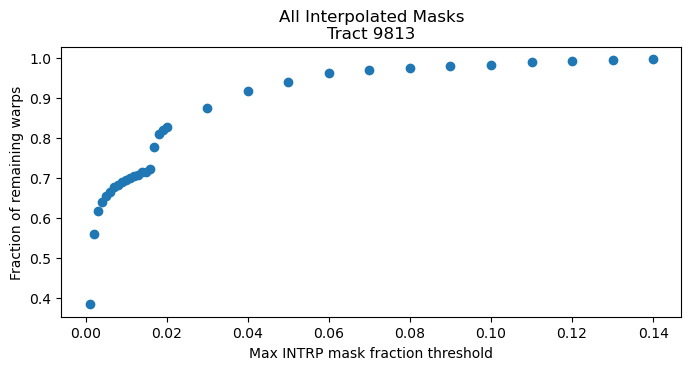

In [173]:
fig, axs = plt.subplots(1, 1, figsize=(8,3.5), sharey=True)
axs.scatter(max_mask_frac_list, data_9813_all[1])

axs.set_title('All Interpolated Masks\nTract 9813')
axs.set_xlabel('Max INTRP mask fraction threshold')
axs.set_ylabel('Fraction of remaining warps')

plt.show()

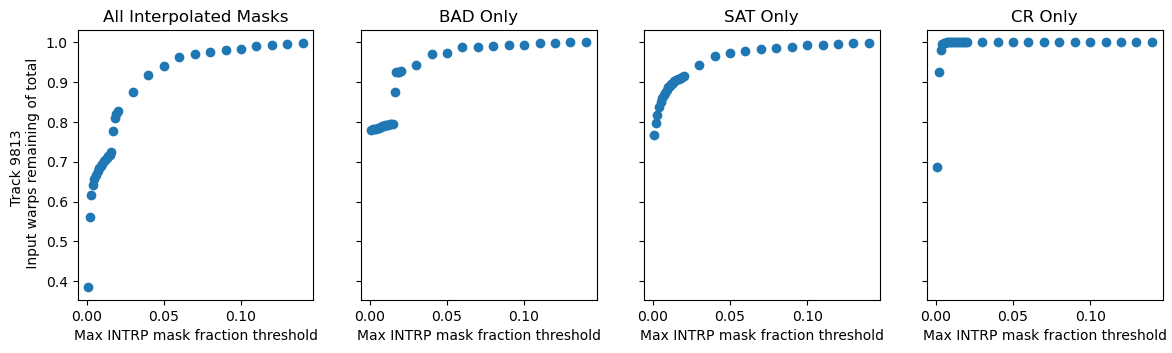

In [129]:
fig, axs = plt.subplots(1, 4, figsize=(14,3.5), sharey=True)
axs[0].scatter(max_mask_frac_list, data_9813_all[1])
axs[0].set_title('All Interpolated Masks')
axs[1].scatter(max_mask_frac_list, data_9813_bad[1])
axs[1].set_title('BAD Only')
axs[2].scatter(max_mask_frac_list, data_9813_sat[1])
axs[2].set_title('SAT Only')
axs[3].scatter(max_mask_frac_list, data_9813_cr[1])
axs[3].set_title('CR Only')

for ax in axs.flat:
    ax.set(xlabel='Max INTRP mask fraction threshold',
           ylabel='Track 9813 \n Input warps remaining of total')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Looking at all three tracts together...

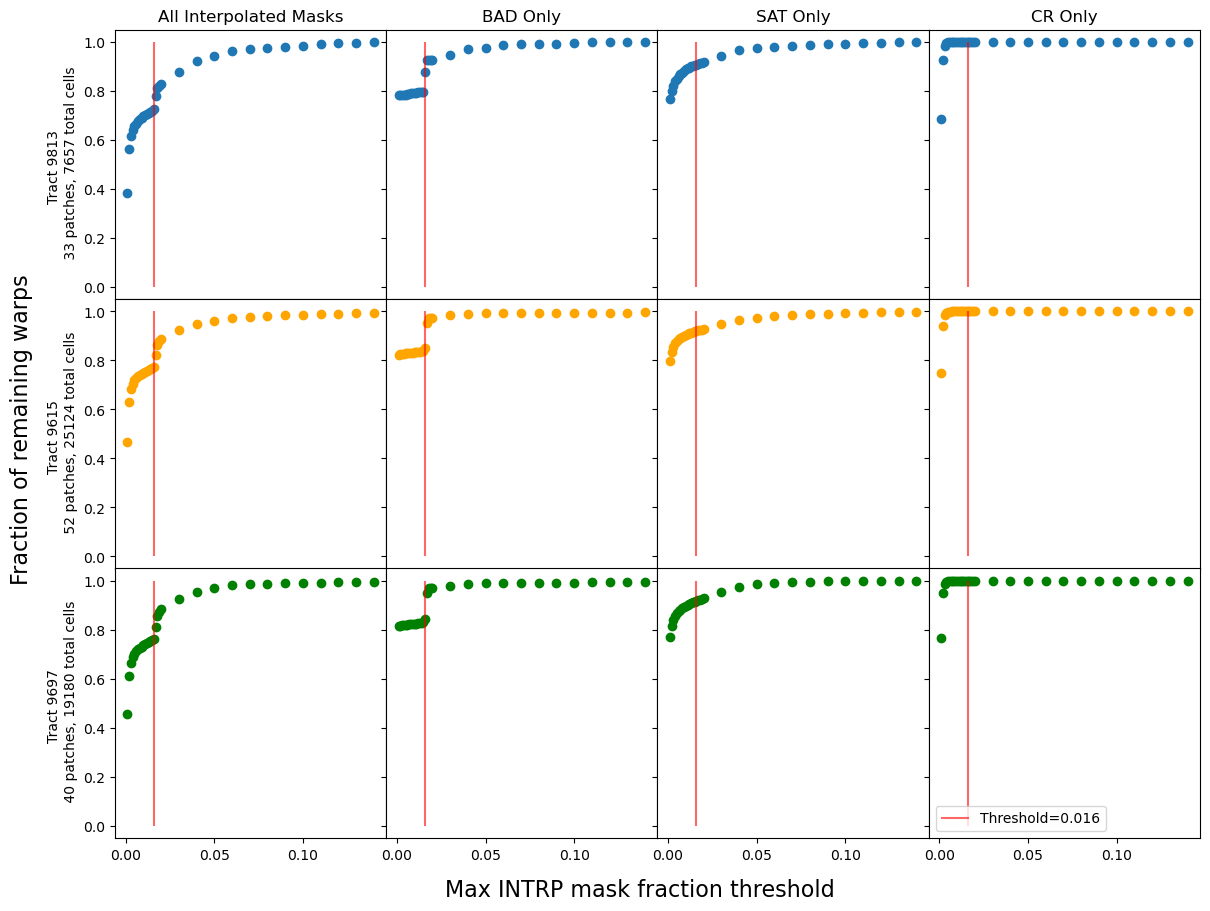

In [142]:
fig, axs = plt.subplots(3, 4, figsize=(14,10.5), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)
axs[0, 0].scatter(max_mask_frac_list, data_9813_all[1])
axs[0, 0].set_ylabel("Tract 9813 \n 33 patches, 7657 total cells")
axs[0, 0].set_title('All Interpolated Masks')
axs[0, 1].scatter(max_mask_frac_list, data_9813_bad[1])
axs[0, 1].set_title('BAD Only')
axs[0, 2].scatter(max_mask_frac_list, data_9813_sat[1])
axs[0, 2].set_title('SAT Only')
axs[0, 3].scatter(max_mask_frac_list, data_9813_cr[1])
axs[0, 3].set_title('CR Only')

axs[1, 0].scatter(max_mask_frac_list, data_9615_all[1], color='orange')
axs[1, 0].set_ylabel("Tract 9615 \n 52 patches, 25124 total cells")
axs[1, 1].scatter(max_mask_frac_list, data_9615_bad[1], color='orange')
axs[1, 2].scatter(max_mask_frac_list, data_9615_sat[1], color='orange')
axs[1, 3].scatter(max_mask_frac_list, data_9615_cr[1], color='orange')

axs[2, 0].scatter(max_mask_frac_list, data_9697_all[1], color='green')
axs[2, 0].set_ylabel("Tract 9697 \n 40 patches, 19180 total cells")
axs[2, 1].scatter(max_mask_frac_list, data_9697_bad[1], color='green')
axs[2, 2].scatter(max_mask_frac_list, data_9697_sat[1], color='green')
axs[2, 3].scatter(max_mask_frac_list, data_9697_cr[1], color='green')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.vlines(0.016, 0, 1, color='r', alpha=0.6, label="Threshold=0.016")

fig.supxlabel("Max INTRP mask fraction threshold", fontsize=16, x=0.5, y=0.05)
fig.supylabel("Fraction of remaining warps", fontsize=16, x=0.05)

plt.legend()

plt.savefig('three-tract-mfrac_divot.png', bbox_inches='tight')

# Collection of single patches in tract 9813

In [70]:
collection = 'u/mgorsuch/cell_coadds_tract_9813_all_34/20240921T195601Z'
tract = 9813

patches = get_patches(collection, tract)

In [108]:
m_frac_mean_list = [[] for i in range(len(patches))]
patch_cells_filled_frac = [0 for i in range(len(patches))]

for patch_index, patch in enumerate(patches):
    warp_mask_fractions, total_inputs, filled_cells_frac = calc_m_frac_patch(collection, tract, patch)
    mean_input_frac_list = calc_input_frac_patch(collection, tract, patch, max_mask_frac_list, warp_mask_fractions, total_inputs)

    m_frac_mean_list[patch_index] = mean_input_frac_list
    patch_cells_filled_frac[patch_index] = filled_cells_frac

np.savetxt(f'{save_folder}/tract_9813_33_patches.txt', m_frac_mean_list, delimiter=',')

In [109]:
np.savetxt(f'{save_folder}/tract_9813_33_patches_cells_filled.txt', patch_cells_filled_frac, delimiter=',')

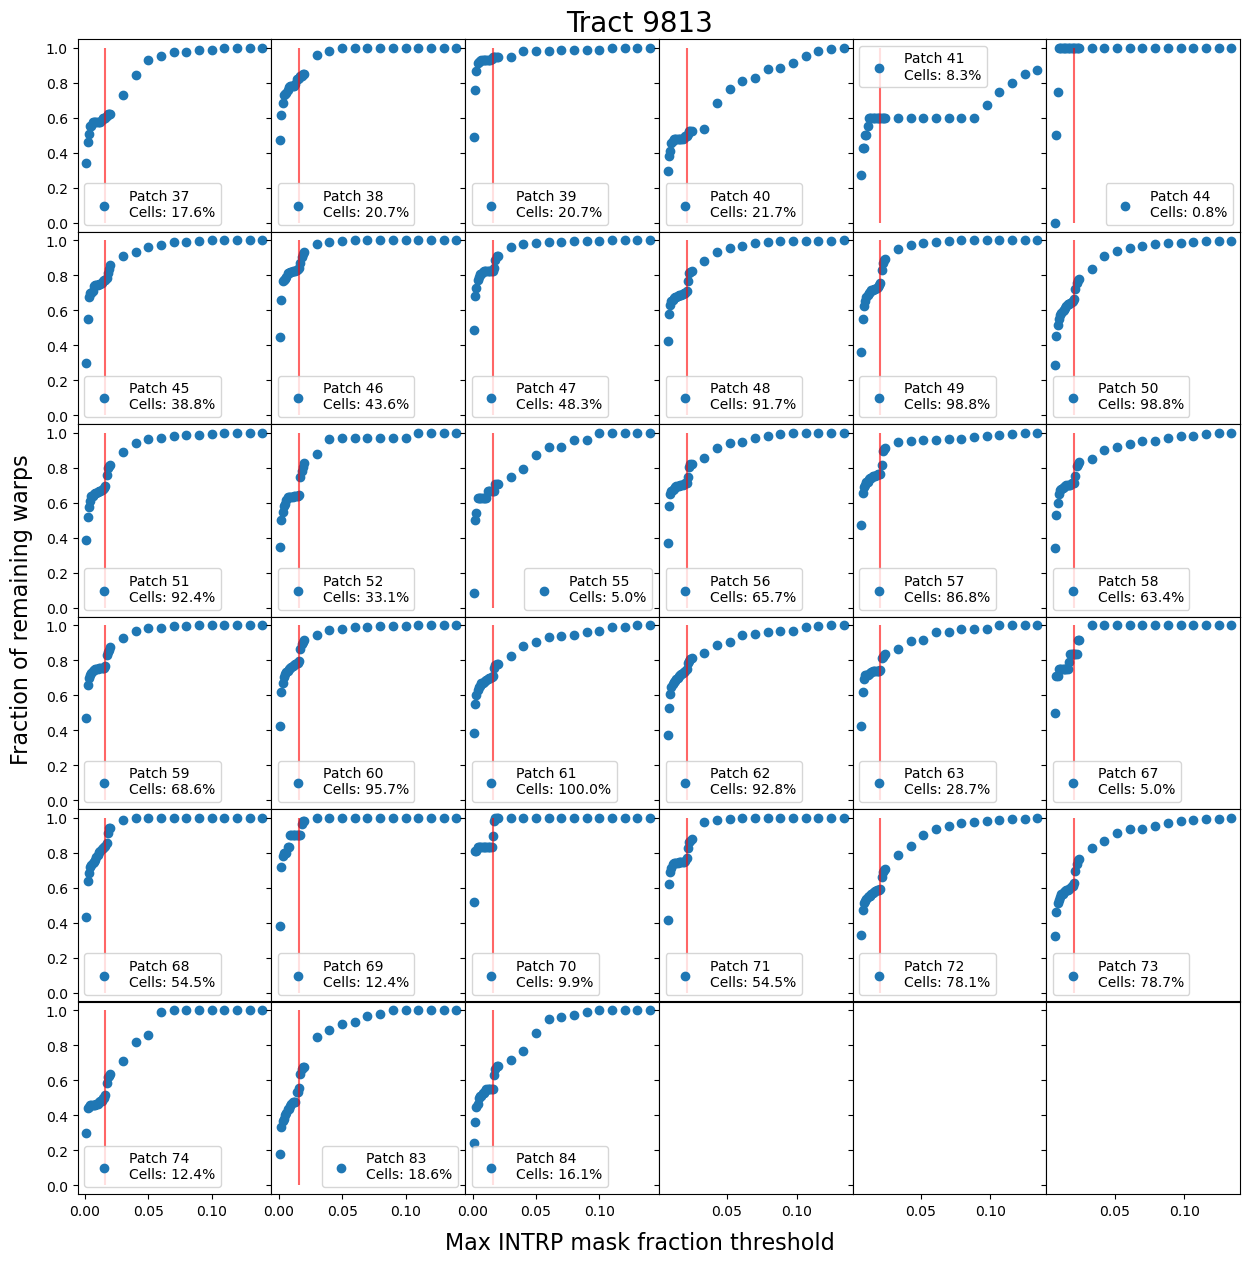

In [127]:
fig, axs = plt.subplots(6, 6, figsize=(15,15), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate(axs.flat):
    # not all axis will be filled by 33 patches
    if ax_index > 32:
        ax.set_xlim([max_mask_frac_list[0], max_mask_frac_list[-1]])
        continue

    ax.scatter(max_mask_frac_list,
               m_frac_mean_list[ax_index], 
               label=f"Patch {patches[ax_index]}\nCells: {patch_cells_filled_frac[ax_index]:.1%}")
    ax.vlines(0.016, 0, 1, color='r', alpha=0.6)
    ax.label_outer()
    ax.legend()

fig.suptitle("Tract 9813", fontsize=20, x=0.5, y=0.90)
fig.supxlabel("Max INTRP mask fraction threshold", fontsize=16, x=0.5, y=0.07)
fig.supylabel("Fraction of remaining warps", fontsize=16, x=0.08)

plt.savefig('tract_9813_patch_m_frac.png', bbox_inches='tight')
plt.show()